In [1]:
import random
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from statistics import mean 
from sklearn.model_selection import train_test_split




In [2]:
# This function prepares the data by reading it from a file and converting it into a dataframe for training and testing
def preprocess(filepath):
    df = pd.read_csv(filepath)
    
    return df


In [3]:
def calc_prior(data):
    # An empty dictionary for prior probabilities of each label
    prior_prob = {}
    
    labels = data['label'].tolist()
    # unique_labels is an array of unique label classes, counts an array showing the number of times each unique label appears in train_df
    unique_labels, counts = np.unique(labels, return_counts = True)
    
    total_num_instances =  counts.sum();
    
    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / total_num_instances).round(2)     
    
    return prior_prob

#train_df = preprocess("/Users/MasaTemma/Desktop/Unimelb subjects (Computing & Software Systems)/2023_sem_1/COMP30027 - Machine Learning/Assignment 1/COMP30027_2023_asst1_data/pop_vs_classical_train.csv")
#calc_prior(train_df)

In [4]:
# This function calculates the likelihood of each features given the class label
def calc_likelihood(data):
    # An empty dictionary of likelihoods
    likelihoods = {}
    
    # A list of unique labels
    unique_labels = np.unique(data['label'].tolist())    
    features_list = data.columns[1:-1]

    # Smoothing 
    epsilon = 0.0001
    
    for feature in features_list:
        feature_values = np.unique(train_df[feature])
        
        # Create a nested dictionary for each feature 
        likelihoods[feature] = {}        
        
        for label in unique_labels:                        
            # Create a nested dictionary for each label 
            likelihoods[feature][label] = {}             
            
            for value in feature_values:                
                # number of instances with the same feature value and the same label 
                count = len(data[(data['label'] == label) & (data[feature] == value)])     
                
                # total number of instances with the same label
                total_label_count  = len(data[data['label'] == label])
                
                # if the probability is 0, apply smoothing
                if count == 0:
                    count = epsilon
                
                likelihoods[feature][label][value] = (count) / (total_label_count)                            
                #print(f"Likelihood of {feature}={value} given label {label} is {likelihoods[feature][label][value]:.10f}")
                
    return likelihoods

In [5]:
# This function calcualtes the posterior probability of each class given the observed features

def calc_posterior(data, prior_prob, likelihoods):
    # posterior probabilities of each row 
    posterior_probs = []    
    features_list = data.columns[1:-1]
    
    # smoothing 
    epsilon = 0.0001
    
    # For every row in the test dataset , calculate the posterior probability of each class labels given the features' values
    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:      
            post_probs[label] = prior_prob[label]            
            for feature in likelihoods:
                if instance[feature] not in likelihoods[feature][label]:
                    # apply smoothing if value of a feature is not found in likelihoods
                    post_probs[label] *= epsilon
                else:
                    post_probs[label] *= likelihoods[feature][label][instance[feature]]
                    
        posterior_probs.append(post_probs)
    
    return posterior_probs
    

In [6]:
# This function calculates prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data):
    prior_prob = calc_prior(data)
    likelihoods = calc_likelihood(data)
            
    return prior_prob, likelihoods


In [7]:
# This function predicts classes for new items in a test dataset

def predict(data, prior_prob, likelihoods):
   # Calculate posterior probabilities
    posterior_probs = calc_posterior(data, prior_prob, likelihoods)

    # Find argmax for each instance
    argmax_labels = []
    for post_prob in posterior_probs:
        max_prob = 0
        max_label = None
        for label in post_prob:
            if label in prior_prob:
                prob = post_prob[label]
                if prob > max_prob:
                    max_prob = prob
                    max_label = label
        if max_label is not None:
            argmax_labels.append(max_label)

    return argmax_labels

In [8]:
# This function evaluates the prediction performance by comparing the model’s class outputs to ground
# truth labels
def evaluate(predictions, true_labels):
    # correctly classified as classical 
    TP = 0
    # correctly classfied as pop
    TN = 0
    # falsely classified as pop when it's actually classical
    FN = 0
    # falsely classified as classical when it's actually pop
    FP = 0
    
    instance_num = len(predictions)
    
    for i in range(instance_num):
        if predictions[i] == true_labels[i]:
            if(predictions[i] == "classical"):
                TP += 1
            else:
                TN += 1
        else:
            if(predictions[i] == "classical"):
                FP += 1
            else:
                FN += 1
    
    accuracy = (TP + TN)  / (TP + TN + FP + FN)
    precision = (TP) / (TP + FP) 
    recall = (TP) / (TP + FN)

    performance = {"accuracy": accuracy, "precision": precision, "recall": recall}
    
    return performance

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [9]:
# call the functions to prepare data, train data, and predict 
train_df = preprocess("datasets/pop_vs_classical_train.csv")
test_df = preprocess("datasets/pop_vs_classical_test.csv")

prior_prob, likelihoods = train(train_df)
predictions = predict(test_df, prior_prob, likelihoods)

true_labels = test_df['label'].tolist()
performance = evaluate(predictions, true_labels)

print(f"Accuracy: {performance['accuracy']}, Precision: {performance['precision']}, Recall: {performance['recall']}")


Accuracy: 0.5581395348837209, Precision: 0.52, Recall: 0.65


### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

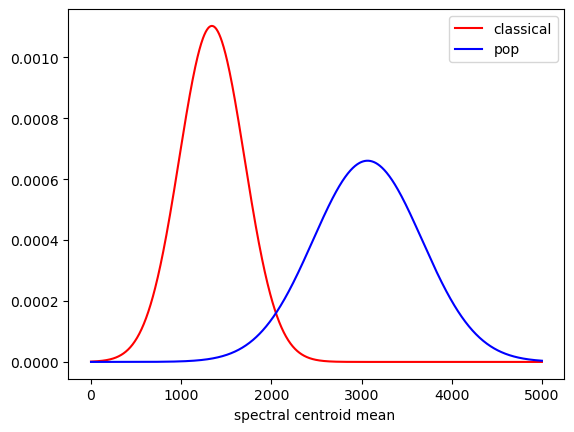

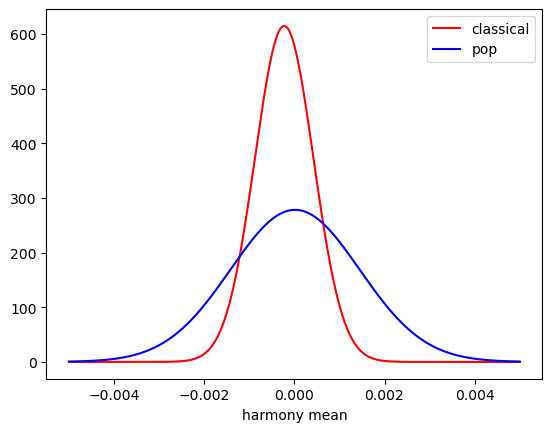

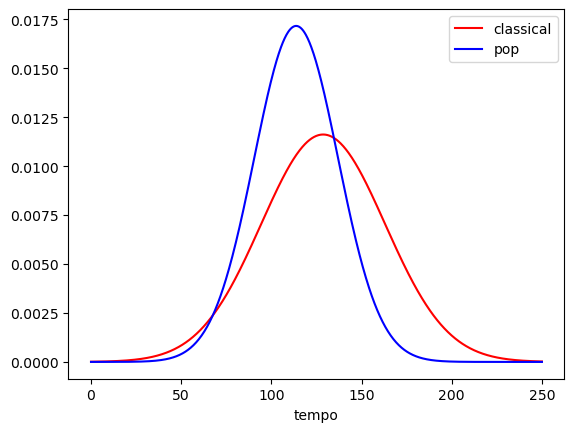

In [10]:
def calculate_mean_sds(data):
    unique_labels = np.unique(data['label'].tolist())    
    features_list = data.columns[1:-1]
    means = {}
    sds = {}
    for feature in features_list:
        means[feature] = {}
        sds[feature] = {}
        for label in unique_labels:
            partial_data = data.loc[data['label'] == label]
            mean = partial_data[feature].mean()
            means[feature][label] = mean
            sds[feature][label] = partial_data[feature].std()
            
    return means, sds


# probability density fucntion
def f(x, mean, sd):
    v = -1 * (((x - mean) ** 2) /(2* (sd **2)))
    return 1/(sd * math.sqrt(2*np.pi)) * np.exp(v)


# Stores means of feature values of each feature with given labels
means, sds = calculate_mean_sds(train_df)

# plot pdf for spectral centroid mean given label classical
x = np.linspace(0, 5000, 1000)
plt.xlabel("spectral centroid mean ")
mean = means['spectral_centroid_mean']['classical']
sd = sds['spectral_centroid_mean']['classical']
plt.plot(x, f(x, mean, sd), color='red', label='classical')
# plot pdf for spectral centroid mean given label pop
mean = means['spectral_centroid_mean']['pop']
sd = sds['spectral_centroid_mean']['pop']
plt.plot(x, f(x, mean, sd), color='blue', label='pop')
plt.legend()
plt.show()
plt.close()


# plot pdf for harmony mean given label classical

x = np.linspace(-0.005, 0.005, 1000)
plt.xlabel("harmony mean")
mean = means['harmony_mean']['classical']
sd = sds['harmony_mean']['classical']
plt.plot(x, f(x, mean, sd), color='red', label='classical')

# plot pdf for harmony mean given label pop
mean = means['harmony_mean']['pop']
sd = sds['harmony_mean']['pop']
plt.plot(x, f(x, mean, sd), color='blue', label='pop')
plt.legend()
plt.show()
plt.close()

# plot pdf for tempo given label classical

x = np.linspace(0, 250, 1000)
plt.xlabel("tempo")
mean = means['tempo']['classical']
sd = sds['tempo']['classical']
plt.plot(x, f(x, mean, sd), color='red', label='classical')

# plot pdf for tempo given label pop
mean = means['tempo']['pop']
sd = sds['tempo']['pop']
plt.plot(x, f(x, mean, sd), color='blue', label='pop')
plt.legend()
plt.show()
plt.close()
    
        

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

In [11]:
def calc_overall_accuracy(predictions, true_labels):

    num_correct = 0
    instance_num = len(predictions)
    for i in range(instance_num):
        if predictions[i] == true_labels[i]:
            num_correct += 1
    
    return num_correct / instance_num


def performance_by_label(predictions, true_labels, label):
    TP = 0
    FP = 0
    FN = 0
    
    instance_num = len(predictions)
    for i in range(instance_num):
        if(true_labels[i] == label):            
            if(predictions[i] == true_labels[i]):
                TP += 1
            else: 
                FN += 1
                
        elif(predictions[i] == label and predictions[i] != true_labels[i]):            
            FP += 1
            
    precision = TP / (TP + FP)    
    recall = TP / (TP + FN)
    
    performance = {'precision': precision, 'recall': recall}
    
    return performance
        

In [12]:
#Using gztan datasets to prepare data, train data, and predict with my naive Bayes model
train_df = preprocess("datasets/gztan_train.csv")
test_df = preprocess("datasets/gztan_test.csv")

prior_prob, likelihoods = train(train_df)
predictions = predict(test_df, prior_prob, likelihoods)


In [13]:
true_labels = test_df['label'].tolist()
unique_labels = np.unique(train_df['label'].tolist()) 
#print out overall accuracy of my naive Bayes model for gztan datasets
overall_accuracy = calc_overall_accuracy(predictions, true_labels)
print(f"Overall Accuracy: {overall_accuracy}")

for label in unique_labels:
    performance = performance_by_label(predictions, true_labels, label)        
    print(f"{label}: Precision: {performance['precision']}, Recall: {performance['recall']}")

Overall Accuracy: 0.165
blues: Precision: 0.5, Recall: 0.05263157894736842
classical: Precision: 0.0, Recall: 0.0
country: Precision: 0.09523809523809523, Recall: 0.125
disco: Precision: 0.2777777777777778, Recall: 0.45454545454545453
hiphop: Precision: 0.17142857142857143, Recall: 0.2857142857142857
jazz: Precision: 0.2, Recall: 0.05555555555555555
metal: Precision: 0.1875, Recall: 0.15
pop: Precision: 0.11764705882352941, Recall: 0.17391304347826086
reggae: Precision: 0.17142857142857143, Recall: 0.42857142857142855
rock: Precision: 0.0, Recall: 0.0


In [20]:
from sklearn.model_selection import train_test_split

# split dataset into k number of subsets and returns the a list of subsets 
def split_data (data, k):
    
    splits = []    
    test_row_num=  len(data) // k

    for i in range(k):
        if(i < k - 1):
            #Setting random_state to make the outputs reproducible  
            training_data, testing_data = train_test_split(data, test_size = test_row_num, random_state=25)
            splits.append(testing_data)
            data = training_data  
        elif(i == k -1):
            splits.append(data)             
        
    return splits

In [39]:
# accuracies of k-fold cross validation where 2 <= k <= 10
all_df = pd.concat([train_df, test_df])
all_splits_accuracies = {}

for k in range(2, 11, 2):
    splits = split_data(all_df, k)
    # Store the accuracies of each fold
    split_accuracies = []
    for i in range(len(splits)):
        # Combine all the folds into one training set except on fold, which is used as a test set
        temp = splits[:i] + splits[i+1:]
        temp_train_df  = pd.concat(temp)
        temp_test_df = splits[i]
        
        # Make predictions on each fold 
        prior_prob, likelihoods = train(temp_train_df)
        predictions = predict(temp_test_df, prior_prob, likelihoods)
        
        # Evaluate the accuracy of each fold
        true_labels = temp_test_df['label'].tolist()
        split_accuracy = calc_overall_accuracy(predictions, true_labels)
        split_accuracies.append(split_accuracy)     
    
    # Get the mean accuracies of all the splits 
    all_splits_accuracies[k] = split_accuracies
    print(split_accuracies)


[0.144, 0.174]
[0.14, 0.05970149253731343, 0.14, 0.06521739130434782]
[0.1724137931034483, 0.11764705882352941, 0.1794871794871795, 0.1111111111111111, 0.08571428571428572, 0.10526315789473684]
[0.13636363636363635, 0.08333333333333333, 0.11538461538461539, 0.13333333333333333, 0.15625, 0.14814814814814814, 0.07692307692307693, 0.1]
[0.13333333333333333, 0.19230769230769232, 0.037037037037037035, 0.08333333333333333, 0.0, 0.08695652173913043, 0.038461538461538464, 0.1111111111111111, 0.0, 0.05555555555555555]


In [47]:
# Get the mean accuracies for each each k folds cross validation 
cross_val_mean_accuracies = {}
for k in range(2, 11, 2):
    cross_val_mean_accuracies[k] = mean(all_splits_accuracies[k])
print(cross_val_mean_accuracies)

{2: 0.15899999999999997, 4: 0.10122972096041533, 6: 0.12860609768904846, 8: 0.11871701793576793, 10: 0.07380961228787315}


### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.